In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
Home = str(Path.home())

import numpy as np
import pandas as pd

import re

import sys
path = f'{Home}/repos/EPObjects/'
sys.path.insert(0, path)

from probabilistic.parameter import ProbabilisticParameters
from probabilistic.energy_predictions import EnergyPrediction, ProbabilisticEnergyPrediction
from ml_models import get_scaling_layer
from helper.run_period_helper import get_run_periods
from service import db_functions as db

2023-06-21 09:57:42.899636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ColorsSolid = ['#1f77b4', '#d62728', '#9467bd', '#2ca02c', '#ff7f0e',]
NumColors = len(ColorsSolid)

def RGBToHex(c):
    c = c.astype(np.int16)
    return '#%02x%02x%02x' %(c[0], c[1], c[2])

def HexToRGB(h):
    return np.array([int(h[i:i+2], base=16) for i in (1, 3, 5)], dtype=np.int16)

def GetWeighedColor(col1, col2='#ffffff', w=0.5):
    c1 = HexToRGB(col1)
    c2 = HexToRGB(col2)
    return RGBToHex((c1 * (1-w)) + (w * c2))

class ColorScale:
    def __init__(self, c1, c2, mi, ma):
        self.Color1 = c1
        self.Color2 = c2
        self.Min = mi
        self.Max = ma
        self.Range = self.Max - self.Min

    def scale(self, value):
        return (value-self.Min)/self.Range
        
    def Color(self, value):
        if isinstance(value, np.ndarray):     
            vs = []
            for v in value:
                vs.append(GetWeighedColor(self.Color1, self.Color2, self.scale(v)))
            return vs
        return GetWeighedColor(self.Color1, self.Color2, self.scale(value))

In [3]:
search_conditions = db.get_search_conditions('tum-gni', 'house-gn')
pps = ProbabilisticParameters.from_df(db.get_columns(search_conditions, db.PARAMETERS, convert_to_df=True))
scaling_df_x = pps.get_scaling_df()
_, targets = get_run_periods(db.get_columns(search_conditions, db.CONSUMPTION, convert_to_df=True))
simulation_results = ProbabilisticEnergyPrediction.from_json(db.get_columns(search_conditions, db.SIMULATION_RESULTS,))
results = simulation_results.Values['Total']

names = [
    "u-value: Walls\n(W/m\u00b2K)",
    "u-value: Floor\n(W/m\u00b2K)",
    "u-value: Roof\n(W/m\u00b2K)",
    "u-value: Window\n(W/m\u00b2K)",
    "g-value\n(-)",
    "Permeability\n(m\u00b3/m\u00b2-h)",
    "Occupancy\n(persons/sq. m.)",
    "Heating\nsetpoint (\N{DEGREE SIGN}C)",
    "Internal mass\n(kJ/m\u00b2)",
    "Light heat\ngain (W/m\u00b2)",
    "Equipment heat\ngain (W/m\u00b2)",
    "Coefficient of\nperformance (-)",
]


In [4]:
results = db.get_columns(search_conditions, db.RESULTS,)
combinations = pd.DataFrame.from_dict(results[db.PARAMETERS])
predictions = pd.DataFrame.from_dict(results[db.PREDICTIONS])

scaling_data = db.get_columns(search_conditions, db.SCALING)
# scaling_df_x = pd.DataFrame.from_dict(scaling_data[db.SCALING_DF_X])
scaling_df_y = pd.DataFrame.from_dict(scaling_data[db.SCALING_DF_Y])

scaling_x = get_scaling_layer(scaled_df=scaling_df_x)
scaling_y = get_scaling_layer(scaled_df=scaling_df_y)

2023-06-21 09:57:47.216486: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 


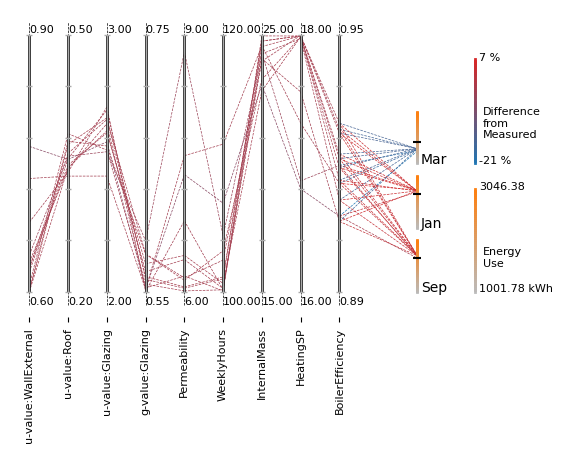

In [5]:
fig, ax = plt.subplots(figsize=(0.5 * len(scaling_df_x) + 2, 4), nrows = 1, ncols = 1)

for i, pp in enumerate(pps):
    ax.plot([i, i], [-.05, 1.05], lw=0.5, ls='--', color='k', zorder=1)
    ax.bar([i, i], [0, 1], width=0.05, ec='k', lw=0.5, zorder=2, color='#aaaaaa')
    plt.plot(i * np.ones((6)), np.linspace(0, 1, 6), marker='_', markersize=5, color='#aaaaaa', lw=0.1)
    
    plt.text(i, -0.05, f'{pp.Min:.02f}', size=8)
    plt.text(i, 1.01, f'{pp.Max:.02f}', size=8)
    
    try: plt.scatter(i, scaled_x[i], 150, marker='_', color='k', zorder=100)
    except: pass

x = scaling_x(combinations).numpy()
y = scaling_y(predictions).numpy()*0.2
errors = pd.DataFrame.from_dict(results[db.ERRORS]).values
total_error = list(results[db.TOTAL_ERROR].values())

error_scale = ColorScale('#1f77b4', '#d62728', min(errors.min(), min(total_error)), max(errors.max(), max(total_error)))

previous = None


for i, chr in enumerate(x):
    for p, x1 in enumerate(chr):
        if previous is not None:
            plt.plot([previous[0], p], [previous[1], x1], lw=0.5, ls='--', color=error_scale.Color(total_error[i]), zorder=-1)
        previous = [p, x1]
    
    for j, t in enumerate(y[i]):
        plt.plot([previous[0], p+2], [previous[1], j*0.25 + t], lw=0.5, ls='--', color=error_scale.Color(errors[i, j]), zorder=-1)
        
    previous = None

results_pos = p+2
consumption_scale = ColorScale('#bbbbbb', '#ff7f0e', 0, 1.0)
breaks = 50
for i, t in enumerate(scaling_df_y.iterrows()):
    plt.text(results_pos+0.1, i*.25, t[0][:3], horizontalalignment='left')
    for j in range(breaks):
        ax.plot([results_pos, results_pos], [i*0.25 + j*0.2/breaks, i*0.25 + (j+1) * 0.2/breaks], lw=2, ls='-', color=consumption_scale.Color(j/breaks), zorder=1)
        if i==0:
            ax.plot([results_pos+1.5, results_pos+1.5], [i*0.25 + j*0.4/breaks, i*0.25 + (j+1) * 0.4/breaks], lw=2, ls='-', color=consumption_scale.Color(j/breaks), zorder=1)
    
ax.text(results_pos+1.6, 0, f'{scaling_df_y["Min"][0]:.02f} kWh', size=8)
ax.text(results_pos+1.7, 0.1, f'Energy\nUse', size=8)
ax.text(results_pos+1.6, 0.4, f'{scaling_df_y["Max"][0]:.02f}', size=8)

increment = error_scale.Range/breaks
for j in np.linspace(error_scale.Min, error_scale.Max, breaks):
    y_start = 0.5 + error_scale.scale(j) * 0.4 
    y_end = 0.5 + error_scale.scale(j+increment) * 0.4
    ax.plot([results_pos+1.5, results_pos+1.5], [y_start, y_end], lw=2, ls='-', color=error_scale.Color(j), zorder=1)
    # break

ax.text(results_pos+1.6, 0.5, f'{error_scale.Min:0.0f} %', size=8)
ax.text(results_pos+1.7, 0.6, f'Difference\nfrom\nMeasured', size=8)
ax.text(results_pos+1.6, 0.9, f'{error_scale.Max:0.0f} %', size=8)

res = scaling_y(targets.values.T).numpy() * 0.2
for i, t in enumerate(res.T):
    ax.scatter([results_pos], [i*0.25 + t[0]], marker='_', color='k')

xticks = tuple(x for x in pps)
ax.set_xticks(range(len(xticks)), labels=pps.get_names(), size=8, rotation=90, horizontalalignment='center', verticalalignment='top')
ax.set_yticks([])
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-.5, results_pos+2.5])

ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

# plt.savefig('test.pdf', bbox_inches='tight')

In [6]:
#half violin plots using seaborn graph
#upper values: parameter estimation (in results: simulationdata.values)
#lower values: combinations, last columns
#y1, y2 from Targets (measured values)
import seaborn as sns
sns.set(rc={'figure.figsize':(6,3)})
sns.set_theme(style="whitegrid")

data = pd.DataFrame()
for x, month in enumerate(Results):
  plt.vlines(x, 2.5, 9.5, lw=0.5, color="grey", linestyle = '-.', zorder=-1) 
  
  d1 = pd.DataFrame()
  d1['Energy'] = Results[month]
  d1['Approach'] = 'Random sampling'
  d1['Month'] = month

  d2= pd.DataFrame()
  d2['Energy'] = Combinations[f'Predicted_{x}']
  d2['Approach'] = 'ML predicted combinations'
  d2['Month'] = month

  data = pd.concat((data, d1, d2))

ax=sns.violinplot(data=data, width=1, x="Month", y="Energy", hue="Approach", split=True, inner=None, linewidth=1, palette="Blues")

for i, value in Targets.iterrows():
    plt.scatter([i, i], value, marker='_', color='k')
    for x, z in enumerate(['2017', '2018']):
        plt.text(i, value[x], f' {z}', verticalalignment='center')

plt.xticks(range(4), [x[:3] for x in Targets.index])

plt.ylabel('Energy Consumption (MWh)')
plt.xlim(-0.5, 3.5)
plt.ylim(2, 10)
plt.grid(axis='y', color='k', linestyle='--', linewidth=0.1)

ax.spines[['right', 'top',]].set_visible(False)
ax.legend(loc = "lower right")
plt.savefig('violin.pdf', bbox_inches='tight')
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
from scipy.stats import norm
from math import sqrt
from scipy.stats import t

import numpy as np
from numpy.random import seed
from numpy.random import rand
from numpy.random import randint
from numpy import mean
from numpy import median, mean

from numpy import percentile

def ConfidenceIntervalWithoutBS(y):
    alpha = 5.0
    lower_p = alpha / 2.0
    lower = percentile(y, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = percentile(y, upper_p)
    print (f'{lower:0.02f}-{upper:0.02f}')
    return lower, upper

def ConfidenceInterval(y, n=50):
    seed(1)
    scores = list()
    dataset = y
    samples = len(dataset)
    for _ in range(n):
        indices = randint(0, samples, samples)
        sample = dataset[indices]
        # calculate and store statistic
        statistic = sqrt(mean(sample))
        scores.append(statistic)
    
    m = mean(scores)
    
    alpha = 5.0
    lower_p = alpha / 2.0
    lower = percentile(scores, lower_p)
    upper_p = (100 - alpha) + (alpha / 2.0)
    upper = percentile(scores, upper_p)

    print (f'{lower:0.02f}-{upper:0.02f}')
    return lower, upper

In [ ]:
for x, month in enumerate(results):
  print (month)
  ConfidenceIntervalWithoutBS(Combinations[f'Predicted_{x}'])
  ConfidenceIntervalWithoutBS(results[month])

In [ ]:
Results